In [1]:
import pickle
import re
import numpy as np
import string
import matplotlib.pyplot as plt

In [2]:
with open('./corpus_and_sentiment.pkl', 'rb') as f:
    corpus_and_sentiment = pickle.load(f)

In [3]:
corpus_train = corpus_and_sentiment['train']['corpus']
sentiment_train = corpus_and_sentiment['train']['sentiment']

corpus_test = corpus_and_sentiment['test']['corpus']
sentiment_test = corpus_and_sentiment['test']['sentiment']

### Normalize Text

In [4]:
url_pattern = re.compile(r'((http(s?))|(pic\.twitter\.com))\S+')
cashtag_pattern = re.compile(r'\$[A-Za-z]+')
atmention_pattern = re.compile(r'\@[A-Za-z]+')
punctuation = ''.join(set(string.punctuation) - set(['@', '$', '#'])) # remove these separately, not part of punctuation
punctuation_pattern = re.compile(r'[%s]+\ *' % re.escape(punctuation))

# Sometimes hashtags contain useful info - for now, I'll just remove the '#' symbol
def normalize_tweet(raw_text, remove_punctuation=True):
    clean_text = re.sub(url_pattern, '', raw_text)
    clean_text = re.sub(cashtag_pattern, '', clean_text)
    clean_text = re.sub(atmention_pattern, '', clean_text)
    
    if remove_punctuation:
        clean_text = re.sub(punctuation_pattern, ' ', clean_text)
    
    clean_text = clean_text.replace('#', '')
    clean_text = clean_text.strip()
    return clean_text

In [5]:
for t in np.random.choice(corpus_train, size=3, replace=False):
    print(t, '\n')
    print(normalize_tweet(t), '\n')

Call of the week: Wall Street gets more bullish on Amazon https://yhoo.it/2oy00Yg $AMZN @SeanaNSmithpic.twitter.com/LXum282B6v 

Call of the week Wall Street gets more bullish on Amazon 

Breaking open the deck with $MSFT! A 10…. pic.twitter.com/ESWBXCyBpd 

Breaking open the deck with  A 10… 

Here's a superlative: $AAPL shares poised for best quarter in five years http://blogs.wsj.com/moneybeat/2017/03/31/apple-poised-for-best-quarter-in-five-years/ … via @WSJMoneyBeat @beneisen 

Here s a superlative shares poised for best quarter in five years  … via 



In [6]:
corpus_train = [normalize_tweet(t) for t in corpus_train]
corpus_test = [normalize_tweet(t) for t in corpus_test]

In [7]:
len(corpus_train), len(corpus_test)

(291, 100)

In [8]:
np.bincount(sentiment_test + 1)

array([12, 63, 25])

### Loughrand McDonald Dictionary

In [9]:
with open('./lm_dictionary_vocab.pkl', 'rb') as f:
    lm_dictionary_vocab = pickle.load(f)
    
lm_pos_words = lm_dictionary_vocab['pos']
lm_neg_words = lm_dictionary_vocab['neg']

### 1. Construct score by (#pos words - #neg words) / length

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from nltk.corpus import stopwords

In [11]:
# STOPS = set(stopwords.words('english'))

In [12]:
cv = CountVectorizer(
    lowercase=True,
#     stop_words=STOPS,
#     min_df=2
)

pos_word_cv = CountVectorizer(
    lowercase=True,
#     stop_words=STOPS,
#     min_df=2,
    vocabulary=lm_pos_words
)

neg_word_cv = CountVectorizer(
    lowercase=True,
#     stop_words=STOPS,
#     min_df=2,
    vocabulary=lm_neg_words
)

In [13]:
count_matrix_test = cv.fit_transform(corpus_test)
count_neg_matrix_test = neg_word_cv.fit_transform(corpus_test)
count_pos_matrix_test = pos_word_cv.fit_transform(corpus_test)

In [14]:
len(lm_neg_words), len(lm_pos_words)

(2355, 354)

In [15]:
count_matrix_test.shape, count_neg_matrix_test.shape, count_pos_matrix_test.shape

((100, 709), (100, 2355), (100, 354))

In [16]:
num_pos_words = np.array(count_pos_matrix_test.sum(axis=1)).flatten()
num_neg_words = np.array(count_neg_matrix_test.sum(axis=1)).flatten()
num_words = np.array(count_matrix_test.sum(axis=1)).flatten()

In [17]:
sentiment_scores = (num_pos_words - num_neg_words) / num_words

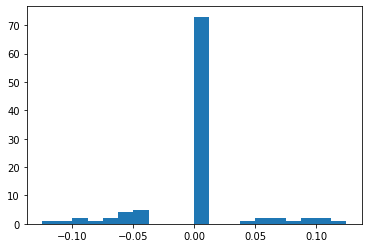

In [18]:
_ = plt.hist(sentiment_scores, bins=20)

In [19]:
sentiment_scores_int = np.where(sentiment_scores < 0, -1, sentiment_scores)
sentiment_scores_int = np.where(sentiment_scores_int > 0, 1, sentiment_scores_int)

In [20]:
sentiment_scores_int = sentiment_scores_int.astype(int)

In [21]:
accuracy_score(sentiment_test, sentiment_scores_int)

0.49

In [22]:
print(classification_report(sentiment_test,
                      sentiment_scores_int))

              precision    recall  f1-score   support

          -1       0.31      0.42      0.36        12
           0       0.59      0.68      0.63        63
           1       0.09      0.04      0.06        25

    accuracy                           0.49       100
   macro avg       0.33      0.38      0.35       100
weighted avg       0.43      0.49      0.46       100



### 3. Use LM Dictionary Words and fit a classifer from train set

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

In [24]:
lm_tfidf = TfidfVectorizer(
    lowercase=True,
#     stop_words=STOPS,
#     min_df=2,
    vocabulary=set(lm_neg_words) | set(lm_pos_words),
    sublinear_tf=True,
)

In [25]:
X_lm_train = lm_tfidf.fit_transform(corpus_train)
X_lm_test = lm_tfidf.transform(corpus_test)

In [26]:
lr = LogisticRegression()

lr.fit(X_lm_train, sentiment_train)
y_lm_pred = lr.predict(X_lm_test)

/home/sjb/virtualenv/stock_research/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/sjb/virtualenv/stock_research/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [27]:
y_lm_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [30]:
accuracy_score(sentiment_test, y_lm_pred)

0.63

In [31]:
print(classification_report(sentiment_test,
                      y_lm_pred))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        12
           0       0.63      1.00      0.77        63
           1       0.00      0.00      0.00        25

    accuracy                           0.63       100
   macro avg       0.21      0.33      0.26       100
weighted avg       0.40      0.63      0.49       100



/home/sjb/virtualenv/stock_research/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [32]:
clf = MultinomialNB()

clf.fit(X_lm_train, sentiment_train)
y_lm_pred_nb = clf.predict(X_lm_test)

In [33]:
y_lm_pred_nb

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

### 4. Use all words to fit a classifier from train set

In [34]:
np.bincount(sentiment_train + 1)

array([ 31, 173,  87])

In [35]:
tfidf = TfidfVectorizer(
    lowercase=True,
#     stop_words=STOPS,
    min_df=2,
    sublinear_tf=True,
)

In [36]:
X_train = tfidf.fit_transform(corpus_train)
X_test = tfidf.transform(corpus_test)

In [37]:
X_train.shape, X_test.shape

((291, 497), (100, 497))

In [38]:
lr = LogisticRegression()

lr.fit(X_train, sentiment_train)
y_pred = lr.predict(X_test)

/home/sjb/virtualenv/stock_research/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/sjb/virtualenv/stock_research/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [42]:
accuracy_score(sentiment_test, y_pred)

0.66

In [43]:
print(classification_report(sentiment_test,
                      y_pred))

              precision    recall  f1-score   support

          -1       1.00      0.08      0.15        12
           0       0.65      1.00      0.79        63
           1       1.00      0.08      0.15        25

    accuracy                           0.66       100
   macro avg       0.88      0.39      0.36       100
weighted avg       0.78      0.66      0.55       100



In [44]:
clf = MultinomialNB()

clf.fit(X_train, sentiment_train)
y_pred_nb = clf.predict(X_test)

In [45]:
y_pred_nb

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  1,  0,  0,  0,  1,  0,  0, -1,  0,  0])

In [46]:
accuracy_score(sentiment_test, y_pred_nb)

0.65

In [47]:
print(classification_report(sentiment_test,
                      y_pred_nb))

              precision    recall  f1-score   support

          -1       1.00      0.08      0.15        12
           0       0.65      0.98      0.78        63
           1       0.67      0.08      0.14        25

    accuracy                           0.65       100
   macro avg       0.77      0.38      0.36       100
weighted avg       0.69      0.65      0.55       100



### Upsample Training Set

In [48]:
neg_corpus_train = np.array(corpus_train)[sentiment_train == -1]
neutral_corpus_train = np.array(corpus_train)[sentiment_train == 0]
pos_corpus_train = np.array(corpus_train)[sentiment_train == 1]

In [49]:
neg_corpus_train.shape, neutral_corpus_train.shape, pos_corpus_train.shape

((31,), (173,), (87,))

In [50]:
neg_corpus_train_upsample = np.random.choice(neg_corpus_train, size=170)
pos_corpus_train_upsample = np.random.choice(pos_corpus_train, size=170)

In [51]:
corpus_train_upsample = np.concatenate(
    (neg_corpus_train_upsample, neutral_corpus_train, pos_corpus_train_upsample)
)

sentiment_train_upsample = np.concatenate(
    (np.ones_like(neg_corpus_train_upsample, dtype=int) * -1,
    np.zeros_like(neutral_corpus_train, dtype=int),
     np.ones_like(pos_corpus_train_upsample, dtype=int)
    )
)

In [52]:
corpus_train_upsample.shape, sentiment_train_upsample.shape

((513,), (513,))

In [53]:
np.bincount(sentiment_train_upsample+1)

array([170, 173, 170])

In [54]:
X_train = tfidf.fit_transform(corpus_train_upsample)
X_test = tfidf.transform(corpus_test)

In [55]:
lr = LogisticRegression()

lr.fit(X_train, sentiment_train_upsample)
y_pred = lr.predict(X_test)

/home/sjb/virtualenv/stock_research/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/sjb/virtualenv/stock_research/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [56]:
accuracy_score(sentiment_test, y_pred)

0.67

In [73]:
print(classification_report(sentiment_test,
                      y_pred))

              precision    recall  f1-score   support

          -1       0.33      0.17      0.22        12
           0       0.72      0.86      0.78        63
           1       0.58      0.44      0.50        25

    accuracy                           0.67       100
   macro avg       0.54      0.49      0.50       100
weighted avg       0.64      0.67      0.64       100

